<a href="https://colab.research.google.com/github/wenchun0731/city-hunter/blob/main/crosswalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


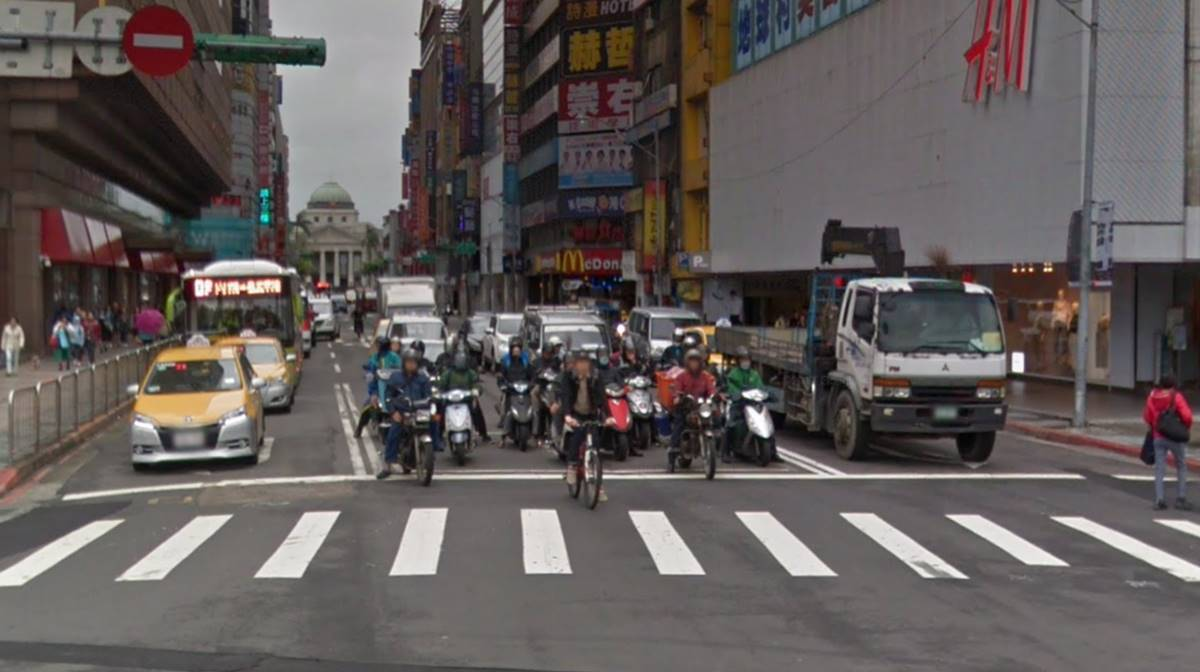

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
image=cv2.imread('/content/1553256727_47700.jpg')
image2=image.copy()
cv2_imshow(image2)

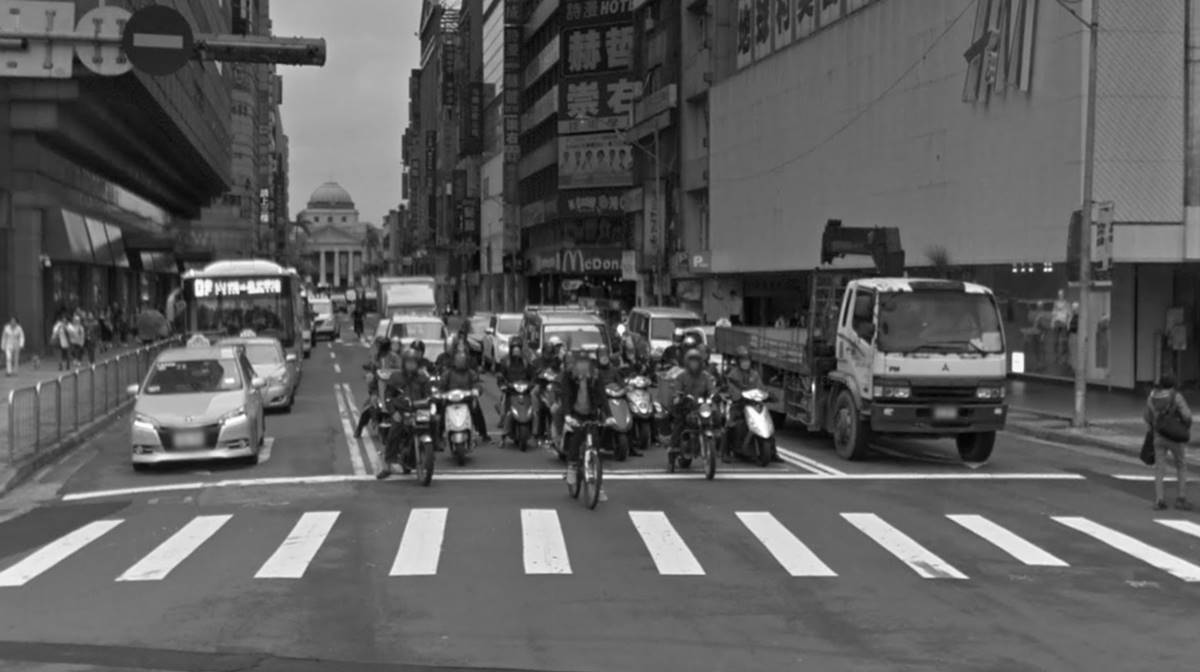

In [ ]:
gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
from google.colab.patches import cv2_imshow
cv2_imshow(gray_img)


In [ ]:
# import numpy as np

# mask=np.ones_like(gray_img)*0
# h,w=mask.shape[0:]
# # print(h,w)
# mask[400:h,200:w]=255
# # mask[0:h,0:w]=255
# mask_edges=cv2.bitwise_and(gray_img,mask)
# cv2_imshow(mask_edges)


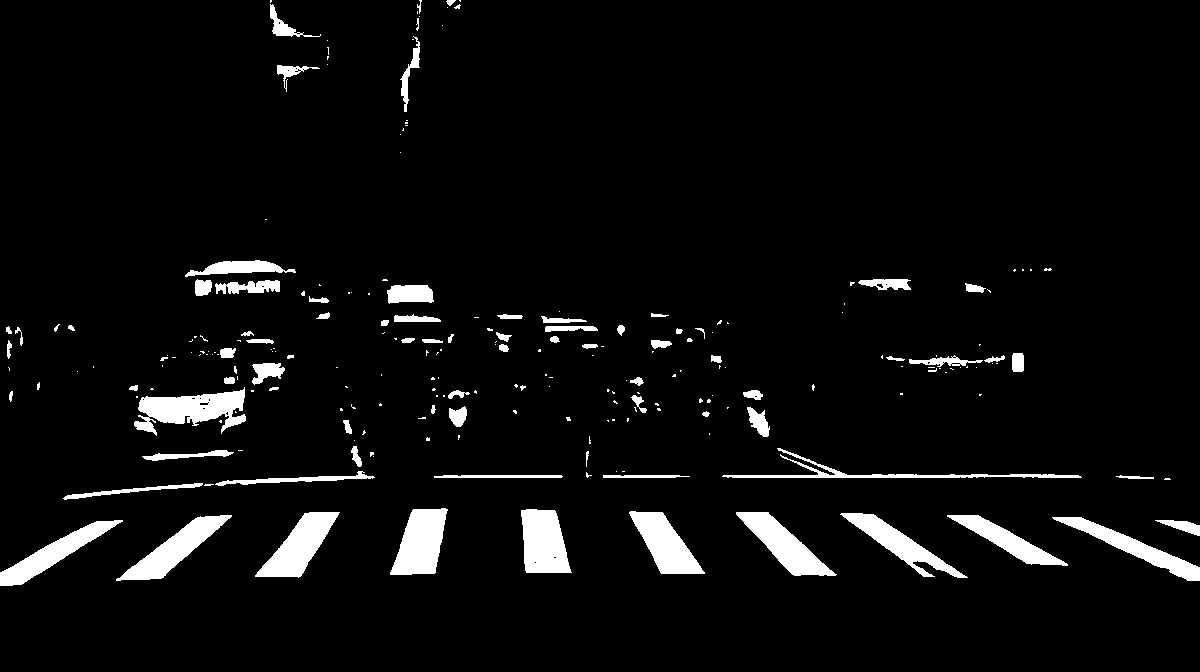

In [ ]:
threshold_value = 180  # 可以根據需要調整
max_value = 255
_, binary_image = cv2.threshold(gray_img, threshold_value, max_value, cv2.THRESH_BINARY)
cv2_imshow(binary_image)


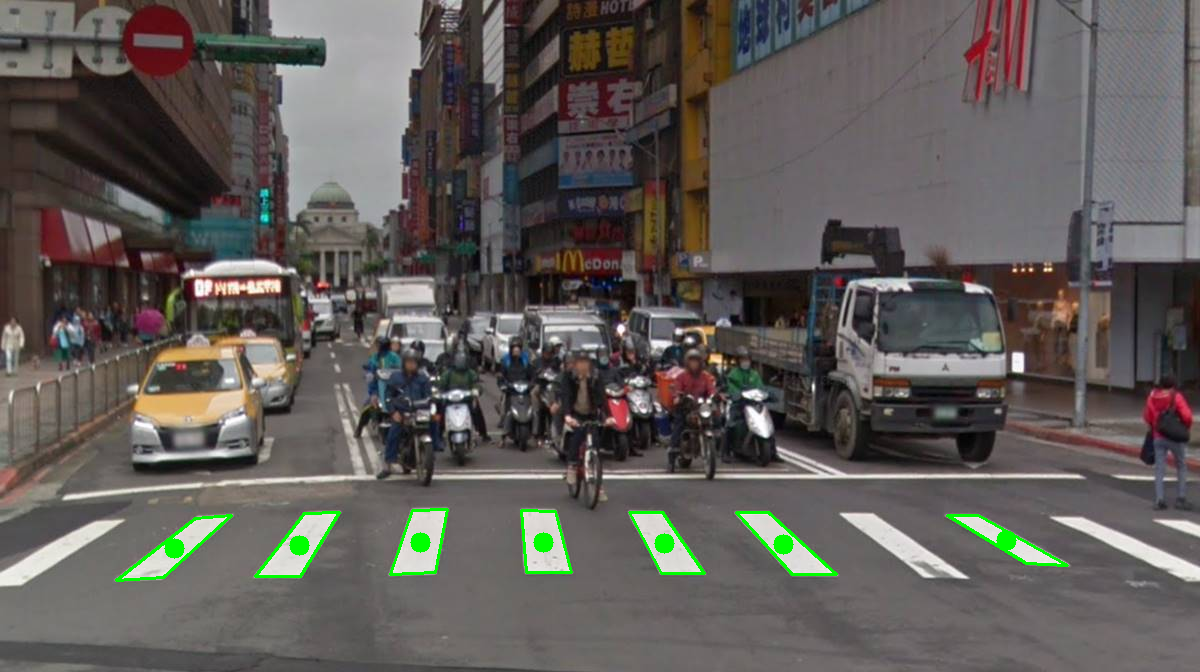

In [ ]:
contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
approx_all=[]
point_all=[]
h,w=binary_image.shape[0:]

for contour in contours:
    #計算面積，看面積有沒有大於1000

    area=cv2.contourArea(contour)
    if area>1500:

      # 使用多邊形逼近法來取得簡化的頂點
      epsilon = 0.01 * cv2.arcLength(contour, True)
      approx = cv2.approxPolyDP(contour, epsilon, True)

      # 檢查是否為四邊形
      if len(approx) == 4:
          # 計算邊的長度比和角度，確認是否為平行四邊形
          # 這裡可以加入計算平行邊的判斷邏輯
          M = cv2.moments(contour)
          if M['m00'] != 0:
              cx = int(M['m10'] / M['m00'])
              cy = int(M['m01'] / M['m00'])

              point_all.append([cx,cy])
              approx_all.append(approx)
              # 在圖像上標記中心點
              cv2.circle(image, (cx, cy), 10, (0, 255, 0), -1)

cv2.drawContours(image, approx_all, -1, (0, 255, 0), 2)

cv2_imshow(image)
image=image2.copy()


moments圖像矩:計算圖像的特徵量

M[m00]面積

M[m01]一階矩

1. 計算間距
2. 研究DBSCAN


在每一個輪廓中，找到輪廓的中心點
所有中心點比對DBSCAN
找到核心點，只取核心點之前的輪廓
找到輪廓的斜率，決定使用x還是y軸排序
分別放入上線及下線的list
只用list製作擬和直線

會有兩組演算法
根據核心點的擬和值線的斜率
決定他是哪個方向

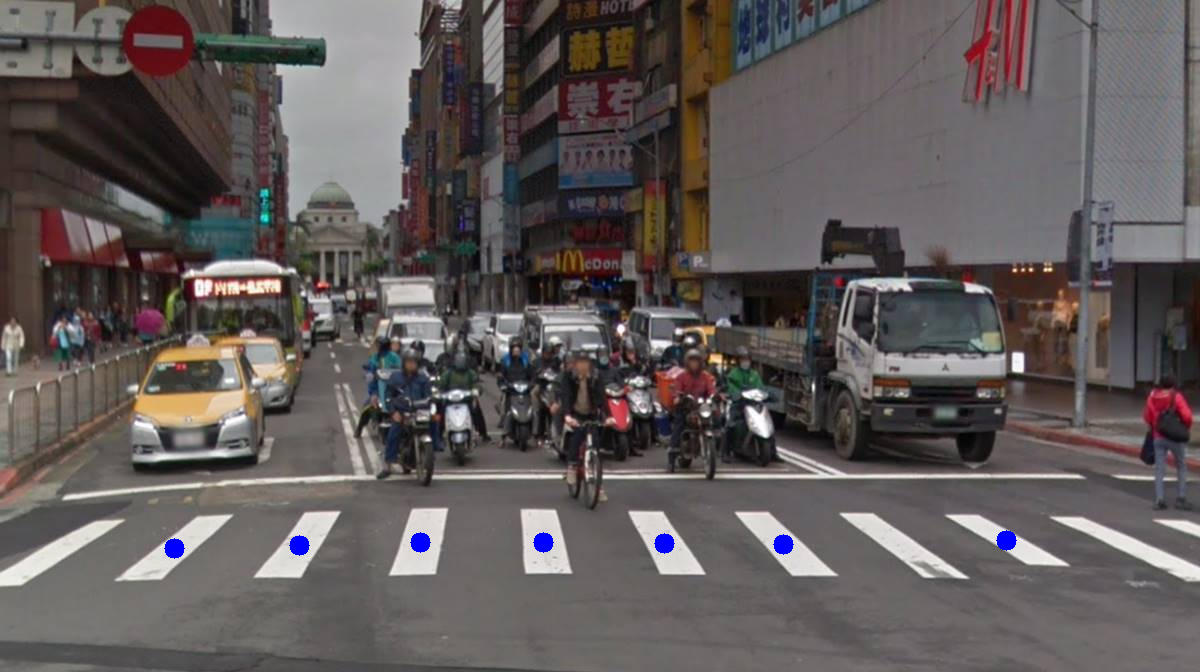

In [ ]:
from sklearn.cluster import DBSCAN
# 設定 DBSCAN 參數
epsilon = 250  # 鄰域距離閾值，視情況調整
min_points = 2  # 至少包含的點數
pointx=[]
pointy=[]
contous_id=[]
# 初始化 DBSCAN 模型
dbscan = DBSCAN(eps=epsilon, min_samples=min_points)
clusters = dbscan.fit_predict(point_all)

# 輸出結果
for i, cluster_id in enumerate(clusters):
    x,y=point_all[i]
    if cluster_id != -1:  # -1 表示噪聲
        cv2.circle(image, (x, y), 10, (255, 0, 0), -1)
        pointx.append(x)
        pointy.append(y)
        contous_id.append(i)
        # print(f"Point {i+1} belongs to cluster {cluster_id}")
    # else:
    #     cv2.circle(image, (cx, cy), 10, (0, 0, 255), -1)
cv2_imshow(image)

回去抓一樣id的輪廓

In [ ]:
print(contous_id)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


篩選要的輪廓

In [ ]:
contour_sort=[] # 要保留的輪廓

for i in contous_id:
  contour_sort.append(approx_all[i])

print(contour_sort)

[array([[[ 947,  515]],

       [[1026,  563]],

       [[1067,  565]],

       [[ 978,  515]]], dtype=int32), array([[[231, 515]],

       [[195, 518]],

       [[116, 580]],

       [[163, 577]]], dtype=int32), array([[[736, 512]],

       [[792, 574]],

       [[836, 574]],

       [[768, 512]]], dtype=int32), array([[[339, 512]],

       [[304, 513]],

       [[255, 576]],

       [[300, 576]]], dtype=int32), array([[[629, 512]],

       [[661, 573]],

       [[704, 573]],

       [[662, 512]]], dtype=int32), array([[[521, 510]],

       [[526, 572]],

       [[571, 572]],

       [[555, 511]]], dtype=int32), array([[[447, 509]],

       [[412, 510]],

       [[390, 574]],

       [[435, 572]]], dtype=int32)]


依照斜率區分要執行哪個演算法

In [ ]:
# 以y軸區分演算法
low_y_point=[]
up_y_point=[]
def contour_sort_y(contour_sort,collabor):
  sorted_array = [sorted(myarray, key=lambda x: x[0][collabor]) for myarray in contour_sort]
  for contour in sorted_array:
    low_y_point.append(contour[:2])
    up_y_point.append(contour[2:])
  return up_y_point,low_y_point


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

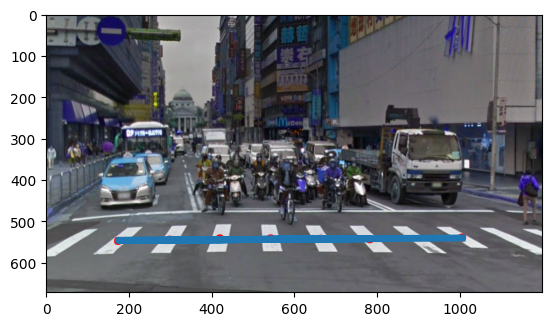

In [ ]:
# 擬合直線
#用來計算多項式的最佳擬合係數
coefficients = np.polyfit(pointx, pointy, 1)
# 提取斜率和截距
linear_fit = np.poly1d(coefficients)
slope=round(coefficients[0],3)
intercept=round(coefficients[1],3)
coefficients_o=[slope,intercept]
#當x等於多少的時候y等於多少
linear_fit_o = np.poly1d(coefficients_o)

# coefficients_one=[slope+0.04,intercept+70]
# #當x等於多少的時候y等於多少

# linear_fit_one = np.poly1d(coefficients_one)

# coefficients_two=[slope-0.075,intercept-25]
# linear_fit_two = np.poly1d(coefficients_two)
# 繪製原始點和擬合的直線
plt.imshow(image)
# plt.plot(pointx, linear_fit_two(pointx), linewidth=5)  # 擬合直線
plt.plot(pointx, linear_fit_o(pointx), linewidth=5)  # 擬合直線
# plt.plot(pointx, linear_fit_two(pointx), linewidth=3)  # 擬合直線
if 1>=abs(slope)>=0:
  #以y軸區分的演算法

  up_y_point,low_y_point=contour_sort_y(contour_sort,1)

else:
  #以x軸區分的演算法
  up_y_point,low_y_point=contour_sort_y(contour_sort,0)



# 顯示圖形
plt.show()

In [ ]:
def change_to_simple_data(numpy_points):
  simple_data=[[point.tolist() for point in points] for points in numpy_points]
  return simple_data

def coefficients_line(pointx,pointy):
  coefficients = np.polyfit(pointx,pointy, 1)
  linear_fit = np.poly1d(coefficients)
  slope=round(coefficients[0],3)
  intercept=round(coefficients[1],3)
  return slope,intercept


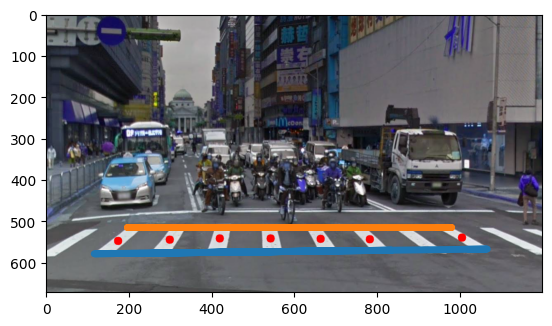

In [ ]:
simple_data=[[point.tolist() for point in points] for points in up_y_point]
simple_data_low=[[point.tolist() for point in points] for points in low_y_point]
pointx=[point[0][0] for points in simple_data for point in points]
pointy=[point[0][1] for points in simple_data for point in points]

coefficients = np.polyfit(pointx,pointy, 1)
linear_fit = np.poly1d(coefficients)
slope=round(coefficients[0],3)
intercept=round(coefficients[1],3)
coefficients_o=[slope,intercept]
# #當x等於多少的時候y等於多少
linear_fit_o = np.poly1d(coefficients_o)
plt.plot(pointx, linear_fit_o(pointx), linewidth=5)  # 擬合直線

pointx=[point[0][0] for points in simple_data_low for point in points]
pointy=[point[0][1] for points in simple_data_low for point in points]

coefficients = np.polyfit(pointx,pointy, 1)
linear_fit = np.poly1d(coefficients)
slope=round(coefficients[0],3)
intercept=round(coefficients[1],3)
coefficients_o=[slope,intercept]
#當x等於多少的時候y等於多少
linear_fit_o = np.poly1d(coefficients_o)

plt.imshow(image)
# plt.plot(pointx, linear_fit_two(pointx), linewidth=5)  # 擬合直線
plt.plot(pointx, linear_fit_o(pointx), linewidth=5)  # 擬合直線
plt.show()

斜率絕對值，在1與0之間以y軸區分

斜率大於1以x軸區分

也就是兩套演算法



In [ ]:
print(slope)

0.298


In [ ]:
from google.colab import drive
from google.colab.patches import cv2_imshow
from sklearn.cluster import DBSCAN
import numpy as np
import cv2
import matplotlib.pyplot as plt

drive.mount('/content/drive')
image=cv2.imread('/content/1553256727_47700.jpg')

class find_up_and_low_slope:
    def __init__(self):
      pass

    def main_findupandlow_slope(self,numpy_point):
      pointx,pointy=self.change_to_simple_data(numpy_point)
      return self.coefficients_line(pointx,pointy)

    #輸出上下線的pointx,pointy
    def change_to_simple_data(self,numpy_point):
      simple_data=[[point.tolist() for point in points] for points in numpy_point]
      pointx=[point[0][0] for points in simple_data for point in points]
      pointy=[point[0][1] for points in simple_data for point in points]
      return pointx,pointy

    def coefficients_line(self,pointx,pointy):
      coefficients = np.polyfit(pointx,pointy, 1)
      linear_fit = np.poly1d(coefficients)
      slope=round(coefficients[0],3)
      intercept=round(coefficients[1],3)
      return slope,intercept

class identify_crosswalk:
  def __init__(self,image):
    self.image=image




  def main_crosswalk(self):
    gray_image=self.opencv_gray()
    binary_image=self.opencv_binary(gray_image)
    point_all,approx_all=self.opencv_contours(binary_image)
    contours_sort,slope=self.opencv_dbscan(point_all,approx_all)
    up_line_information,low_line_information=self.slope_judge(contours_sort,slope[0])
    return point_all,up_line_information,low_line_information

  def opencv_gray(self):
    gray_img = cv2.cvtColor(self.image,cv2.COLOR_BGR2GRAY)

    return gray_img

  def opencv_binary(self,image):
    threshold_value = 180  # 可以根據需要調整
    max_value = 255
    _, binary_image = cv2.threshold(image, threshold_value, max_value, cv2.THRESH_BINARY)
    return binary_image

  def opencv_contours(self,image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # 所有要得輪廓
    approx_all=[]
    # 所有要得中心點
    point_all=[]

    for contour in contours:
        #計算面積，看面積有沒有大於1000

        area=cv2.contourArea(contour)
        if area>1500:

          # 使用多邊形逼近法來取得簡化的頂點
          epsilon = 0.01 * cv2.arcLength(contour, True)
          approx = cv2.approxPolyDP(contour, epsilon, True)

          # 檢查是否為四邊形
          if len(approx) == 4:
              # 計算邊的長度比和角度，確認是否為平行四邊形
              # 這裡可以加入計算平行邊的判斷邏輯
              M = cv2.moments(contour)
              if M['m00'] != 0:
                  cx = int(M['m10'] / M['m00'])
                  cy = int(M['m01'] / M['m00'])

                  point_all.append([cx,cy])
                  approx_all.append(approx)
    return point_all,approx_all

  #找到要得中心點的擬合直線，使用斜率判斷contour_line_sort演算法
  def opencv_dbscan(self,point_all,approx_all):
    pointx=[]
    pointy=[]
    contours_sort=[] # 要保留的輪廓
    # 設定 DBSCAN 參數
    epsilon = 250  # 鄰域距離閾值，視情況調整
    min_points = 2  # 至少包含的點數

    # 初始化 DBSCAN 模型
    dbscan = DBSCAN(eps=epsilon, min_samples=min_points)
    clusters = dbscan.fit_predict(point_all)

    # 輸出結果
    for i, cluster_id in enumerate(clusters):
        x,y=point_all[i]
        if cluster_id != -1:  # -1 表示噪聲
            # cv2.circle(image, (x, y), 10, (255, 0, 0), -1)
            pointx.append(x)
            pointy.append(y)

            contours_sort.append(approx_all[i])
    slope=find_up_and_low_slope()
    slope=slope.coefficients_line(pointx,pointy)
    return contours_sort,slope

  #找到上下線的點點，輸出斜率與截距
  def contour_line_sort(self,contour_sort,collabor):
    low_line_point=[]
    up_line_point=[]
    sorted_array = [sorted(myarray, key=lambda x: x[0][collabor]) for myarray in contour_sort]
    for contour in sorted_array:
      low_line_point.append(contour[:2])
      up_line_point.append(contour[2:])

    up=find_up_and_low_slope()
    up_line_slope=up.main_findupandlow_slope(up_line_point)
    low=find_up_and_low_slope()
    low_line_slope=low.main_findupandlow_slope(low_line_point)

    return up_line_slope,low_line_slope



  # 以y軸區分演算法



  def slope_judge(self,contour_sort,slope):
    if 1>=abs(slope)>=0:
      #以y軸區分的演算法
      return self.contour_line_sort(contour_sort,1)
    else:
      #以x軸區分的演算法
      return self.contour_line_sort(contour_sort,0)

information=identify_crosswalk(image)
point_all,up_information,low_information=information.main_crosswalk()
print(point_all,up_information,low_information)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[[174, 548], [783, 544], [299, 545], [664, 543], [543, 542], [420, 542]] (-0.007, 577.789) (-0.006, 515.18)


# 三個參數(斜率,截距,行人座標)
輸入是車子座標與行人座標

low_y=-x*slope+(intercept+25)

up_y=-x*slope+(intercept-25)

In [ ]:
class TrafficViolationDetector:
    def __init__(self, image_data, up_information, low_information, frame_count, frame, image_data_copy, point_all):
        self.image_data = image_data
        self.image_data_copy=image_data_copy
        self.frame = frame
        self.up_information = up_information
        self.low_information = low_information
        self.frame_count=frame_count
        self.point_all=point_all

    def detect_violations(self):
        return self.data_sort()


    def data_sort(self):
      if 'person' in self.image_data and 'car' in self.image_data:
          for tag, data in self.image_data.items():
              if tag=='car' or tag=='person':

                for data_k, data_v in data.items():
                    # 確保 data_v 是列表而不是字符串
                    if isinstance(data_v, list):
                        for id, coordinate in enumerate(data_v):
                            # 檢查是否為有效的坐標
                            if len(coordinate) >= 2 and self.on_crosswalk(coordinate[0], coordinate[1]):
                                data_v[id] = coordinate
                            else:
                                data_v[id] = []
                        # 過濾空陣列
                        self.image_data[tag][data_k] = [item for item in data_v if item]
          return self.rule_judge()



    def on_crosswalk(self,x,y):
        up_slope=self.up_information[0]
        up_intercept=self.up_information[1]
        low_slope=self.low_information[0]
        low_intercept=self.low_information[1]

        low_y = low_slope * x + low_intercept
        up_y = up_slope * x + up_intercept
        return up_y > y > low_y

    def rule_judge(self):
        people_data = self.image_data['person']
        car_data = self.image_data['car']

        for c_k, c_v in car_data.items():

            is_violation = False
            for p_v in people_data.values():

                if is_violation:
                    break
                for c_data, p_data in [[c, p] for c in c_v for p in p_v]:

                    if self.distance_cal(c_data, p_data):
                        is_violation = True
                        violate_information=self.you_violation(c_k)
                        return violate_information


    def distance_cal(self, car, person):
        point_all_copy=copy.deepcopy(self.point_all)
        point_all_copy.append(car)
        point_all_copy.append(person)

        sorted_point_all = sorted(point_all_copy, key=lambda x: x[0])
        car_index=sorted_point_all.index(car)
        person_index=sorted_point_all.index(person)

        return abs(car_index-person_index) <= 3

    def you_violation(self, id):
        if id not in rule_id:

            violation_frame_count.append(self.frame_count)
            #找到違規車輛的車牌是多少的函示
            plates_id=self.find_plates(id)
            if plates_id == None:
              return None
            else:
              rule_id.append(id)
              # rule_plates.append(plates_id)
              car_img_croppped,plates_img_cropped=self.load_on_database(id,plates_id)
              return [self.frame_count,car_img_croppped,plates_img_cropped]
            # print(f'在第{self.frame_count}偵的時候，車輛{id}違規,他的車牌id是{plates_id}')
            # self.clear_list(self.image_data)

    # # 定義清空列表的函式
    # def clear_list(self,lst):
    #     lst.clear()  # 使用 clear() 方法清空列表

    def coor_min_max(self,what_coor):
        min_value = min(min(sublist) for sublist in what_coor)
        max_value = max(max(sublist) for sublist in what_coor)
        return min_value,max_value
    def find_plates(self,id):
        #從image_data['car'][id]找到車輛座標
        rule_car_coordinate=self.image_data['car'][id]
        if 'licence' in self.image_data:
          rule_plates_coordinate=self.image_data['licence']



          all_distance=[]
          car_min,car_max=self.coor_min_max(rule_car_coordinate)
          for plates_id,plates_coordinates in rule_plates_coordinate.items():
            plates_min,plates_max=self.coor_min_max(plates_coordinates)
            x_minus = abs(plates_min - car_min)
            y_minus = abs(plates_max - car_max)
            if y_minus == 0:
                distance = x_minus

            elif x_minus == 0:
                distance = y_minus
            else:
                distance = math.hypot(x_minus, y_minus)
            all_distance.append([plates_id,distance])
          cars_plates_id = min(all_distance, key=lambda x: x[1])
          return cars_plates_id[0]
        else:

          return None

    def load_on_database(self,id,plates_id):
        car_cropped_img=self.img_cropped('car',id)
        plate_cropped_img=self.img_cropped('licence',plates_id)

        # _, car_img_encoded = cv2.imencode('.jpg', car_cropped_img)
        # _, plate_img_encoded = cv2.imencode('.jpg', plate_cropped_img)

        # return car_img_encoded.tobytes(), plate_img_encoded.tobytes()
        return car_cropped_img, plate_cropped_img

    def img_cropped(self,object,coorid):
        object_coordinate=self.image_data_copy[object][coorid]

        # 找到 x 和 y 的最小最大值
        x_min = min(point[0] for point in object_coordinate)  # 找到最小的 x 值
        x_max = max(point[0] for point in object_coordinate)  # 找到最大的 x 值
        y_min = min(point[1] for point in object_coordinate)  # 找到最小的 y 值
        y_max = max(point[1] for point in object_coordinate)  # 找到最大的 y 值
        # print(object_coordinate)
        # 直接裁剪图像（矩形）
        cropped_img = self.frame[y_min:y_max, x_min:x_max]
        return cropped_img